In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# r in earth radius units
# log g is base10 logarithm of gravity at the shell in CGS
# mass is in solar units

length_unit = 1477 # meters 
time_unit = 4.927*1e-6 # seconds
M_solar = 1.989*1e30 # kg


In [3]:
from math import pi

def Rho(P):
    return np.sqrt(P/K_ns)

def RHS(r, vec):
    """
    :param r: radius 
    :param vec: (m, nu, P)
    :return: D(vec)/Dr vector
    """
    m,nu,P = vec[:]
    rho = Rho(P)
    
    dmdr = 4*pi*(r**2)*rho
    
    dnudr = 2*(m + 4*pi*(r**3)*P) / (r*(r-2*m)) if r > 1e-6 else 0
    
    dPdr = (-1/2)*(rho + P)*dnudr
    
    return np.array([dmdr, dnudr, dPdr])


def RK4(r, vec, dx):
    assert (not np.any(np.isnan(vec))) or (not np.any(np.isinf(vec)))
    
    k1 = dx*RHS(r, vec)
    k2 = dx*RHS(r+0.5*dx, vec + 0.5*k1)
    k3 = dx*RHS(r+0.5*dx, vec + 0.5*k2)
    k4 = dx*RHS(r+dx,vec + k3)

    vec += (k1 + 2*k2 + 2*k3 + k4)/6
    return vec
    
    
def integrate_TOV(rho_c, K_ns, tol=1e-8, dx=1e-4):
    vec0 = np.array([0, 0, K_ns*rho_c**2],dtype=float)
    vec_array = []
    r0 = 0
    
    while abs(vec0[-1]) > tol:
        vec0 = RK4(r0, vec0, dx)[:]
        r0 += dx
        
        vec_array.append(vec0)
        
    return np.array(vec_array), r0

    

In [4]:
from scipy.integrate import solve_ivp

K_ns = 100
rho_vec = np.logspace(-4,0,40)
print("Total rho vals:", len(rho_vec))

M_R_data = []

for i,rho_c in enumerate(rho_vec):
    print("Integration ", i+1)
    data, R = integrate_TOV(rho_c, K_ns)
    M = data[-1,0]
    
    M_R_data.append([R,M])
    
M_R_data = np.array(M_R_data)




Total rho vals: 40
Integration  1
Integration  2
Integration  3
Integration  4
Integration  5
Integration  6
Integration  7
Integration  8
Integration  9
Integration  10
Integration  11
Integration  12
Integration  13
Integration  14
Integration  15
Integration  16
Integration  17
Integration  18
Integration  19
Integration  20
Integration  21
Integration  22
Integration  23
Integration  24
Integration  25
Integration  26
Integration  27
Integration  28
Integration  29
Integration  30
Integration  31
Integration  32
Integration  33
Integration  34
Integration  35
Integration  36
Integration  37
Integration  38
Integration  39
Integration  40


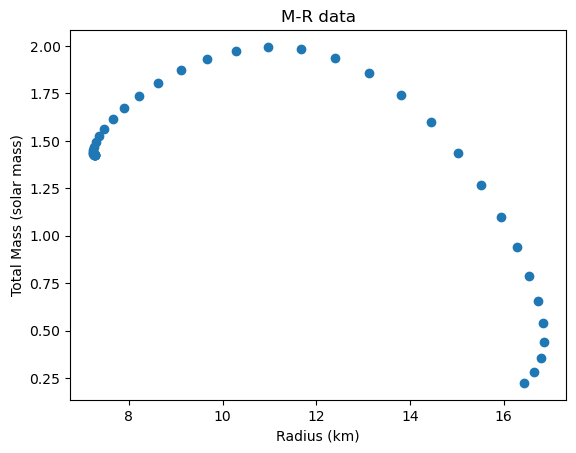

In [5]:
plt.scatter(M_R_data[:,0]*length_unit*1e-3, M_R_data[:,1])
plt.title("M-R data")
plt.xlabel("Radius (km)")
plt.ylabel("Total Mass (solar mass)")
plt.show()

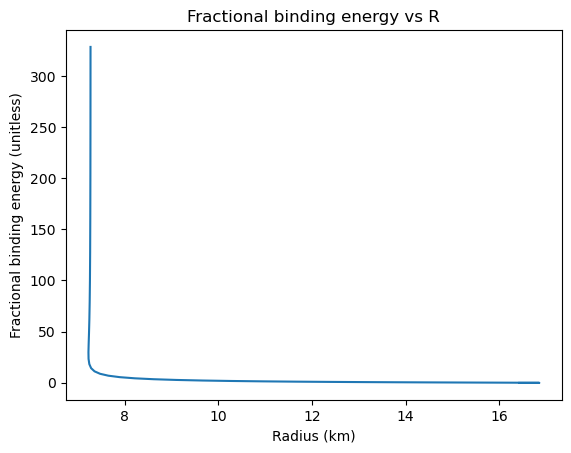

In [6]:
# Calculate binding energy

M_vec = M_R_data[:,1]
R_vec = M_R_data[:,0]

Mp_vec = 4*pi*((1-2*M_vec/R_vec)**(-1/2))*(R_vec**2)*rho_vec
delta_vec = (Mp_vec - M_vec) / M_vec

plt.plot(R_vec*length_unit*1e-3, delta_vec)
plt.title("Fractional binding energy vs R")
plt.xlabel("Radius (km)")
plt.ylabel("Fractional binding energy (unitless)")
plt.show()


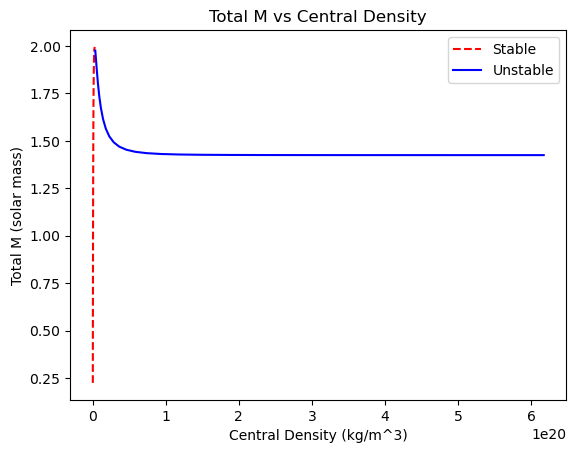

Max stable mass: 1.9946815635419355


In [7]:
# Plot stable and unstable regions
Mdiff_vec = M_vec[1:]-M_vec[:-1]

sign_change_index = [np.sign(Mdiff_vec[i]*Mdiff_vec[i+1]) for i in range(len(Mdiff_vec)-1)].index(-1)

stable_region = M_vec[:sign_change_index+2]
max_stable_M = stable_region[-1]
unstable_region = M_vec[sign_change_index+2:]

density_multiplier = (M_solar/(length_unit**3))

plt.title("Total M vs Central Density")
plt.xlabel("Central Density (kg/m^3)")
plt.ylabel("Total M (solar mass)")
plt.plot(rho_vec[:len(stable_region)]*density_multiplier, stable_region, "--", c="r", label="Stable")
plt.plot(rho_vec[len(stable_region):]*density_multiplier, unstable_region, "-", c="b", label="Unstable")
plt.legend()
plt.show()
print("Max stable mass:", max_stable_M)


### Plotting K versus maximal M

We converted all the code above into a procedure that takes K_ns as an input

In [8]:

# Function Definitions
def Rho(P, K_ns):
    return np.sqrt(P / K_ns)

def RHS(r, vec, K_ns):
    m, nu, P = vec
    rho = Rho(P, K_ns)
    
    dmdr = 4 * pi * (r**2) * rho
    dnudr = 2 * (m + 4 * pi * (r**3) * P) / (r * (r - 2*m)) if r > 1e-4 else 0
    dPdr = (-1 / 2) * (rho + P) * dnudr
    
    return np.array([dmdr, dnudr, dPdr])

def RK4(r, vec, dx, K_ns):
    k1 = dx * RHS(r, vec, K_ns)
    k2 = dx * RHS(r + 0.5 * dx, vec + 0.5 * k1, K_ns)
    k3 = dx * RHS(r + 0.5 * dx, vec + 0.5 * k2, K_ns)
    k4 = dx * RHS(r + dx, vec + k3, K_ns)

    return vec + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def integrate_TOV(rho_c, K_ns, tol=1e-5, dx=1e-3):
    vec0 = np.array([0, 0, K_ns * rho_c**2], dtype=float)
    r0 = 0
    
    while abs(vec0[-1]) > tol:
        vec0 = RK4(r0, vec0, dx, K_ns)
        r0 += dx
    
    return vec0[0], r0

def find_max_stable_mass(K_ns, plotting=False):
    rho_vec = np.logspace(-4, 0, 25)
    M_R_data = []
    
    for rho_c in rho_vec:
        M, R = integrate_TOV(rho_c, K_ns)
        M_R_data.append([R, M])
    
    M_R_data = np.array(M_R_data)
    M_vec = M_R_data[:, 1]
    
    # Identify stable and unstable regions
    Mdiff_vec = M_vec[1:] - M_vec[:-1]
    sign_change_index = next(i for i in range(len(Mdiff_vec) - 1) if np.sign(Mdiff_vec[i] * Mdiff_vec[i + 1]) == -1)
    
    max_stable_M = M_vec[sign_change_index + 1]

    if plotting:
        # Optional: Plotting
        plt.title("Total M vs Central Density")
        plt.xlabel("Central Density")
        plt.ylabel("Total M")
        plt.plot(rho_vec[:sign_change_index + 2], M_vec[:sign_change_index + 2], "--", c="r", label="Stable")
        plt.plot(rho_vec[sign_change_index + 2:], M_vec[sign_change_index + 2:], "-", c="b", label="Unstable")
        plt.legend()
        plt.show()

    return max_stable_M

# Example usage
max_stable_mass = find_max_stable_mass(K_ns=120, plotting=False)
print("Max stable mass:", max_stable_mass)


Max stable mass: 2.1019657727246206


In [9]:
K_vec = np.arange(50,200,10)
max_M_vals = []

for K in K_vec:
    print(K)
    max_mass = find_max_stable_mass(K)
    max_M_vals.append(max_mass)

50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


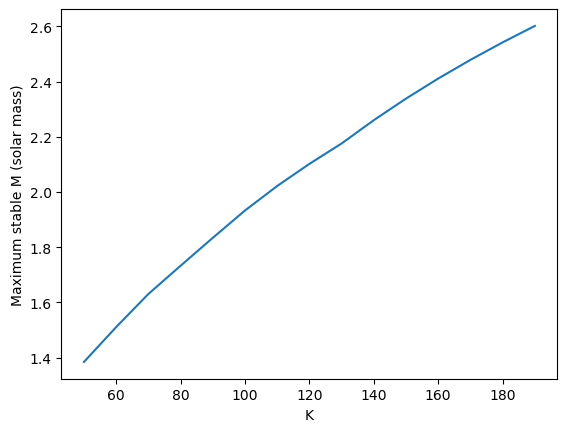

In [10]:
plt.plot(K_vec, np.array(max_M_vals))
plt.xlabel("K")
plt.ylabel("Maximum stable M (solar mass)")
plt.show()

In [11]:
# Allowed K values
max_M_vals = np.array(max_M_vals)

idx = np.where(max_M_vals < 2.14)
max_K = np.amax(K_vec[idx])
print("Allowed K values are smaller than: ", max_K)



Allowed K values are smaller than:  120
